In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
import numpy as np
%matplotlib inline

In [2]:
def clean_raw(bc_full_df):
    import numpy as np
    import pandas as pd
    import pandas as pd
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    %matplotlib inline

    #alsways drop these cols
    bc_full_df = bc_full_df.drop('Worksheet Filter',axis=1)
    bc_full_df = bc_full_df.drop('Measure Display',axis=1)
    bc_full_df = bc_full_df.drop('Number of Records',axis=1)
    bc_full_df = bc_full_df.drop('Unnamed: 0',axis=1)
    bc_full_df = bc_full_df.drop('State',axis=1)
    bc_full_df = bc_full_df.drop('Table Id',axis=1)
    bc_full_df = bc_full_df.drop('Period Duration',axis=1)
    bc_full_df = bc_full_df.drop('Period Begin',axis=1)
    
    #drop when doing neighborhoods
#     bc_full_df = bc_full_df.drop('months_of_supply',axis=1)
#     bc_full_df = bc_full_df.drop('months_of_supply_yoy',axis=1)
#     bc_full_df = bc_full_df.drop('months_of_supply_mom',axis=1)
#     bc_full_df = bc_full_df.drop('Price Drops',axis=1)
#     bc_full_df = bc_full_df.drop('Price Drops Yoy',axis=1)
#     bc_full_df = bc_full_df.drop('Price Drops Mom',axis=1)

    #lgo transforms of two variables so I can potentially use the additive decomposition
    bc_full_df['Inventory'] = np.log(bc_full_df['Inventory'])
    bc_full_df['months_of_supply'] = np.log(bc_full_df['months_of_supply'])


    #rename months_of_supply
    bc_full_df.rename(columns = {'months_of_supply': 'Months of Supply',
                                'months_of_supply_mom': 'Months of Supply Mom',
                                'months_of_supply_yoy': 'Months of Supply Yoy'}, inplace=True)

    #drop 2nd date col
#     dates = ['Period End'] #dropped Period End
#     for col in dates:
#         bc_full_df[col] = pd.to_datetime(bc_full_df[col])
    
    #format percent cols
    percents = ['Median Sale Price Mom',
    'Median Sale Price Yoy',
    'New Listings Mom',
    'New Listings Yoy',
    'Homes Sold Mom',
    'Homes Sold Yoy',
    'Inventory Mom',
    'Inventory Yoy',
    'Avg Sale To List Mom',
    'Avg Sale To List Yoy']
    for col in percents:
        bc_full_df[col] = bc_full_df[col].str.strip('%')
        bc_full_df[col] = pd.to_numeric(bc_full_df[col])
        
    #format money cols
    prices = ['Median Sale Price']
    for col in prices:
        bc_full_df[col] = bc_full_df[col].str.strip('$').str.strip('K').str.replace(',','')
        bc_full_df[col] = pd.to_numeric(bc_full_df[col])
    
    #change scale
    bc_full_df['Median List Price'] = bc_full_df['Median List Price'] / 1000.0
    
    #set index
    bc_full_df['Period End'] = pd.to_datetime(bc_full_df['Period End'])
    bc_full_df = bc_full_df.sort_values('Period End')
    bc_full_df = bc_full_df.set_index('Period End')
    
    return bc_full_df

In [3]:
def test_stationarity(timeseries):
    from statsmodels.tsa.stattools import adfuller
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(6, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [4]:
#test_stationarity(differenced(bos['Median Dom']).values.ravel())

In [5]:
def decomp(series,trend=False,seas=False,resid=True,model='add'):
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    df = pd.DataFrame()
    col_decomp = sm.tsa.seasonal_decompose(series, model=model,two_sided=False)
    #df[col] = col_decomp.observed
    if trend:
        df[series.name+' Trend'] = col_decomp.trend
    if seas:
        df[series.name+' Seasonal'] = col_decomp.seasonal
    if resid:
        df[series.name+' Residual'] = col_decomp.resid
    return df#, target_trend, target_seasonal

In [6]:
def diff(series,lag1=True,lag12=True):
    df = pd.DataFrame()
    lag = (series-series.shift(1)).dropna(axis=0)
    if lag1 and lag12:
        df[series.name+' Lag'] = (lag - lag.shift(12)).dropna()
    elif lag1:
        df[series.name+' Lag1'] = lag
    elif lag12:
        df[series.name+' Lag12'] = (series - series.shift(12)).dropna()
    return df

In [7]:
def read_data(df,reg_type='metro'):
    #format data
    df = clean_raw(df)
    
    #create wide version of file
    #reg_type = 'place'
    rn_master_df = pd.DataFrame()
    for reg in [reg for reg in df[df['Region Type'] == reg_type]['Region'].unique()]:
        reg_df = df[df['Region'] == reg]
        #print('---'+reg)
        rn_reg_df = pd.DataFrame()
        for prop in [prop for prop in reg_df['Property Type'].unique()]:
            prop_df = reg_df[reg_df['Property Type'] == prop]
            rn_dict = {}
            #print('--'+prop)
            for col in [col for col in prop_df.columns if prop_df[col].dtype != 'object']:
                rn_dict[col] = reg+' '+prop+' '+col
                #print(reg+' '+prop+' '+col)
            prop_df = prop_df.rename(columns=rn_dict)
            prop_df = prop_df.drop([col for col in prop_df.columns if prop_df[col].dtype == 'object'],axis=1)
            rn_reg_df = pd.concat([rn_reg_df,prop_df],axis=1)
        rn_master_df = pd.concat([rn_master_df,rn_reg_df],axis=1)
        
    #drop 'object' columns from renamed master
    #rn_master_df = rn_master_df.drop([col for col in rn_master_df.columns if rn_master_df[col].dtype == 'object'],axis=1)
    
    return rn_master_df

In [8]:
def subset(df,term):
    import re
    return df[[col for col in df.columns if re.findall(term,col)]]

In [9]:
def plot(df,term,fig=(15,4)):
    #term = 'Median Sale Price'
    import re
    df[[col for col in df.columns if re.findall(term+'$',col)]].plot(figsize=fig)

In [10]:
#plot(df,'Single Family Residential Median Sale Price',(15,8))

In [11]:
#plot(df_combo,'Median Sale Price.+Residual')

# Comparison between the residuals of decomposition vs differencing
They seem to tell two different stories, maybe I should keep both?

In [12]:
# difference(bos['Median Dom']).plot()
# decomp(bos['Median Dom']).plot()

# test_stationarity(difference(df['Median Dom']).values.ravel())
# test_stationarity(decomp(df['Median Dom']).dropna().values.ravel())

In [13]:
def difference(df,cols,drop_orig=True):
    for col in cols:
        df = pd.concat([df,diff(df[col])],axis=1)
        if drop_orig:
            df.drop(col,axis=1,inplace=True)
    return df

In [14]:
def decompose(df,cols,drop_orig=True,resid=True,trend=False,seas=False):
    for col in cols:
        df = pd.concat([df,decomp(df[col],resid=resid,trend=trend,seas=seas)],axis=1)
        if drop_orig:
            df.drop(col,axis=1,inplace=True)
    #target_trend = decomp(df[col],resid=False,trend=True)
    #target_seas = decomp(df[col],resid=False,seas=True)
    return df#, target_trend, target_seas

In [15]:
def decompose_target(df,cols,drop_orig=True,resid=False,trend=True,seas=True):
    target_trend = decomp(df[col],resid=resid,trend=trend)
    target_seas = decomp(df[col],resid=resid,seas=seas)
    return pd.Series(target_trend), pd.Series(target_seas)

In [16]:
def scatter(df_combo,term):
    #term = 'Lag'
    import re
    import seaborn as sns
    fig, axes = plt.subplots(nrows=6, ncols=6)

    thing = [col for col in df_combo.columns if re.findall(term+'\\b',col)]

    for i, ax in enumerate(axes.reshape(-1)):
        df_combo.plot(x=[col for col in df_combo.columns if re.findall('Median Sale Price '+term+'\\b',col)][0]
                ,y=thing[i],kind='scatter',ax=ax,figsize=(18,18))

In [17]:
def create_supervised(df,term):    
    bos = df.copy()
    target = [col for col in bos.columns if re.findall(term+'$',col)][0]
    #print(target)
    #target = 'Median Sale Price'
    for col in [col for col in bos.columns if col != target]:
        if term not in col:
            for t in range(0,14):
                bos[col+' T-'+str(t)] = bos[col].shift(t)
            bos.drop(col,axis=1,inplace=True)
        else:
            for t in range(1,14):
                bos[col+' T-'+str(t)] = bos[col].shift(t)
            bos.drop(col,axis=1,inplace=True)
    
    for f in range(1,2):
        bos[target+' T+'+str(f)] = bos[target].shift(-f)

    bos.drop(target,axis=1,inplace=True)    
    bos = bos.dropna(axis=0)
    return bos

In [18]:
# import pandas as pd
# import re
# import matplotlib.pyplot as plt
# import statsmodels.api as sm
# import seaborn as sns

# df = pd.read_csv('./bost_camb_full.csv')
# df = read_data(df)
# df = subset(df,'Boston, MA')
# #df = subset(df,'Townhouse')
# df = df.dropna(axis=1)
# df_decomp = decompose(df,df.columns)
# df_diff = difference(df,df.columns)
# df_combo = pd.concat([df_decomp,df_diff],axis=1)
# df_combo = df_combo.dropna(axis=0)

In [19]:
#plot(df_combo,'.+Median Sale Price Lag')
#plot(df_combo,'Median Sale Price Residual')

# case shiller

In [20]:
import glob

#csvs = glob.glob('/Volumes/Secondary/Downloads/boston_*_data_data_full.csv')
csvs = glob.glob('./Case Shiller Index/*.csv')

case_shiller_df = pd.DataFrame()
for csv in csvs:
    df = pd.read_csv(csv)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.set_index('DATE')
    case_shiller_df = pd.concat([case_shiller_df,df],axis=1)

In [21]:
#case_shiller_df

# top 50 metros

In [22]:
# multi_top50 = pd.read_csv('./multi_top50.csv',sep='\t',encoding='utf-16')
# townhouse_top50 = pd.read_csv('./townhouse_top50.csv',sep='\t',encoding='utf-16')
# single_top50 = pd.read_csv('./single_top50.csv',sep='\t',encoding='utf-16')
# condo_top50 = pd.read_csv('./condo_top50.csv',sep='\t',encoding='utf-16')
# all_top50 = pd.read_csv('./all_top50.csv',sep='\t',encoding='utf-16')

In [23]:
# top50 = pd.concat([multi_top50,townhouse_top50,single_top50,condo_top50,all_top50])

In [24]:
# top50.to_csv('raw_top50.csv')

In [25]:
# raw = pd.read_csv('./raw_top50.csv')
# df = read_data(raw)

In [26]:
# df.to_csv('clean_top50.csv')

In [27]:
# df = pd.read_csv('./clean_top50.csv')

# works

In [28]:
df = pd.read_csv('./clean_metros.csv')
df['Period End'] = pd.to_datetime(df['Period End'])
df = df.set_index('Period End')

In [29]:
raw.groupby(['Region','Property Type'])['Median Sale Price'].size().head()

NameError: name 'raw' is not defined

# make functions

In [30]:
def TestTrainTimes(time_list):
    end_first_3_years = time_list[0]
    start_middle_3_years = time_list[1]
    end_middle_3_years = time_list[2]
    start_last_3_years = time_list[3]
    start_last_6_years = time_list[4]
    return end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years

In [31]:
def Target(df_orig,target,city_df,time_list):
    end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years = TestTrainTimes(time_list)
    #setup target variables
    y_last_6 = df_orig[start_last_6_years:][target]
    y_mid_6 = y_last_6[start_middle_3_years:end_middle_3_years]
    y_last_3 = df_orig[start_last_3_years:][target]
    #save target
    city_df = pd.concat([city_df,y_last_3],axis=1)
    return city_df

In [32]:
def ARMA(df_orig,target,city_df,resid_df,time_list,param):
    end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years = TestTrainTimes(time_list)
    #arma
    #param = (16,0,1)
    mod = sm.tsa.statespace.SARIMAX(df_orig[target],order=param,enforce_stationarity=False,enforce_invertibility=False)
    results = mod.fit()
    #setup target variables
    y_last_6 = df_orig[start_last_6_years:][target]
    y_mid_6 = y_last_6[start_middle_3_years:end_middle_3_years]
    y_last_3 = df_orig[start_last_3_years:][target]
    #arma prediction
    best_arma_pred_last_6 = results.predict(start_last_6_years,dynamic=False)
    best_arma_pred_mid_3 = best_arma_pred_last_6[start_middle_3_years:end_middle_3_years]
    best_arma_pred_last_3 = results.predict(start_last_3_years,dynamic=False)
    best_arma_pred_last_3.name = target+' Best ARMA '+str(param)
    #arma residual from target
    best_arma_resid_last_6 = (y_last_6 - best_arma_pred_last_6)
    best_arma_resid_last_6.name = target+' Best ARMA Resid'
    #save pred
    if y_last_3.name in city_df.columns:
        city_df = pd.concat([city_df,best_arma_pred_last_3],axis=1)
    else:
        city_df = pd.concat([city_df,y_last_3,best_arma_pred_last_3],axis=1)        
    #save pred when gridsearching
    #city_df = pd.concat([city_df,y_last_3,best_arma_pred_last_3],axis=1)
    #save resid
    resid_df = pd.concat([resid_df,best_arma_resid_last_6],axis=1)
    return city_df, resid_df, best_arma_pred_last_3

In [397]:
def ARMA2(df_orig,target,city_df,resid_df,time_list,param):
    end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years = TestTrainTimes(time_list)
    #arma
    #param = (16,0,1)
    mod = sm.tsa.statespace.SARIMAX(df_orig[target],order=param,enforce_stationarity=False,enforce_invertibility=False)
    results = mod.fit()
    #setup target variables
    y_last_6 = df_orig[start_last_6_years:][target]
    y_mid_6 = y_last_6[start_middle_3_years:end_middle_3_years]
    y_last_3 = df_orig[start_last_3_years:][target]
    #arma prediction
    best_arma_pred_last_6 = results.predict(start_last_6_years,dynamic=False)
    best_arma_pred_last_6.name = target+' Best ARMA '+str(param)
    best_arma_pred_mid_3 = best_arma_pred_last_6[start_middle_3_years:end_middle_3_years]
    best_arma_pred_last_3 = results.predict(start_last_3_years,dynamic=False)
    best_arma_pred_last_3.name = target+' Best ARMA '+str(param)
    #arma residual from target
    best_arma_resid_last_6 = (y_last_6 - best_arma_pred_last_6)
    best_arma_resid_last_6.name = target+' Best ARMA Resid'
    #save pred
    if y_last_6.name in city_df.columns:
        city_df = pd.concat([city_df,best_arma_pred_last_6],axis=1)
    else:
        city_df = pd.concat([city_df,y_last_6,best_arma_pred_last_6],axis=1)        
    #save pred when gridsearching
    #city_df = pd.concat([city_df,y_last_3,best_arma_pred_last_3],axis=1)
    #save resid
    resid_df = pd.concat([resid_df,best_arma_resid_last_6],axis=1)
    return city_df, resid_df, best_arma_pred_last_3

In [57]:
def SARMA(df_orig,target,city_df,time_list,param,param_seasonal):
    end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years = TestTrainTimes(time_list)
    #sarma
#     param = (12,1,1)
#     param_seasonal = (1,1,1,12)
    mod = sm.tsa.statespace.SARIMAX(df_orig[target],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
    results = mod.fit()
    #sarma prediction
    best_sarma_pred_last_6 = results.predict(start_last_6_years,dynamic=False)
    best_sarma_pred_mid_3 = best_sarma_pred_last_6[start_middle_3_years:end_middle_3_years]
    best_sarma_pred_last_3 = results.predict(start_last_3_years,dynamic=False)
    best_sarma_pred_last_3.name = target+' Best SARMA '+str(param)
    #target
    y_last_3 = df_orig[start_last_3_years:][target]
    #save pred
    if y_last_3.name in city_df.columns:
        city_df = pd.concat([city_df,best_sarma_pred_last_3],axis=1)
    else:
        city_df = pd.concat([city_df,y_last_3,best_sarma_pred_last_3],axis=1)  
    #save pred
#     city_df = pd.concat([city_df,best_sarma_pred_last_3],axis=1)
    return city_df

In [406]:
def SARMA2(df_orig,target,city_df,time_list,param,param_seasonal):
    end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years = TestTrainTimes(time_list)
    #sarma
#     param = (12,1,1)
#     param_seasonal = (1,1,1,12)
    mod = sm.tsa.statespace.SARIMAX(df_orig[target],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
    results = mod.fit()
    #sarma prediction
    best_sarma_pred_last_6 = results.predict(start_last_6_years,dynamic=False)
    best_sarma_pred_last_6.name = target+' Best SARMA '+str(param)
    best_sarma_pred_mid_3 = best_sarma_pred_last_6[start_middle_3_years:end_middle_3_years]
    best_sarma_pred_last_3 = results.predict(start_last_3_years,dynamic=False)
    best_sarma_pred_last_3.name = target+' Best SARMA '+str(param)
    #target
    y_last_6 = df_orig[start_middle_3_years:][target]
    #save pred
    if y_last_6.name in city_df.columns:
        city_df = pd.concat([city_df,best_sarma_pred_last_6],axis=1)
    else:
        city_df = pd.concat([city_df,y_last_6,best_sarma_pred_last_6],axis=1)  
    #save pred
#     city_df = pd.concat([city_df,best_sarma_pred_last_3],axis=1)
    return city_df

In [34]:
def PRED_ARMA_RESID(df_orig,target,best_arma_pred_last_3,best_arma_resid_last_6,city_df,time_list):
    end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years = TestTrainTimes(time_list)
    #predict arma resid
    term = target+' Best ARMA Resid'
    df = df_orig.copy()
    df = pd.concat([df,best_arma_resid_last_6],axis=1)
    city_dict = {}
    #initilize
    all_top_feat_df = pd.DataFrame()
    #build df can handle multiple property types if given
    for target_col in [col for col in df.columns if re.findall(term+'$',col)]:
        print(target_col)
        #top_feat_df = pd.DataFrame()
        df_super = create_supervised(df,target_col)
        top_feat = list(zip(list(df_super.corr()[target_col+' T+1'].abs().sort_values(ascending=False).head(10).index),
                            list(df_super.corr()[target_col+' T+1'].abs().sort_values(ascending=False).head(10))))
        #collect top 10 corr per target
        top_feat_df = pd.DataFrame(top_feat)
        top_feat_df.columns = [target_col,target_col+' Corr']
        top_feat_df = top_feat_df.set_index(target_col)
        all_top_feat_df = pd.concat([all_top_feat_df,top_feat_df],axis=1)
        #save each df_super in this dictionary, drop nan rows from lagging vars
        city_dict[target_col] = df_super
    #loop through dfs within the city_dict and 
    df = city_dict[term]

    #target var, X and y
    target_t1 = term+' T+1'
    X = df.drop([target_t1],axis=1)
    y = df[target_t1]
    #timewise
    X_train = X[start_middle_3_years:end_middle_3_years]
    y_train = y[start_middle_3_years:end_middle_3_years]
    X_test = X[end_middle_3_years:]
    y_test = y[end_middle_3_years:]
    #model
    #reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10),n_estimators=100)
    #reg = LinearSVR(C=.1, epsilon=5)
    reg = RandomForestRegressor(n_estimators=200)
    #reg = ElasticNet(l1_ratio=.3) 
    #model fit
    reg.fit(X_train,y_train)
    best_arma_resid_pred_last_3 = reg.predict(X_test)
    best_arma_resid_pred_last_3 = pd.Series(best_arma_resid_pred_last_3)
    best_arma_resid_pred_last_3.index = y_test.index
    best_arma_resid_pred_last_3.name = target+' Best ARMA Resid Pred'
    best_arma_add_pred_last_3 = (best_arma_pred_last_3-best_arma_resid_pred_last_3)
    best_arma_add_pred_last_3.name = target+' Best ARMA Add'
    score = cross_val_score(reg,X,y,scoring='neg_mean_squared_error')
    print(np.sqrt(-score).mean())
    #save pred
    city_df = pd.concat([city_df,best_arma_add_pred_last_3],axis=1)
    return city_df

In [390]:
def DECOMP(df_orig,target,city_df,time_list):
    end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years = TestTrainTimes(time_list)
    term = target
    df = df_orig.copy()

    #either decompose or diff, then clean up 
    df = decompose(df,df.columns)
    term = target+' Residual'
    df = df.dropna(axis=0)

    #target variable - Remember its Lag or Residual if using diff/decomposition
    city_dict = {}

    #initilize
    all_top_feat_df = pd.DataFrame()

    #run loop for each property type
    for target_col in [col for col in df.columns if re.findall(term+'$',col)]:
        print(target_col)
        #top_feat_df = pd.DataFrame()
        df_super = create_supervised(df,target_col)
        top_feat = list(zip(list(df_super.corr()[target_col+' T+1'].abs().sort_values(ascending=False).head(10).index),
                            list(df_super.corr()[target_col+' T+1'].abs().sort_values(ascending=False).head(10))))

        #collect top 10 corr per target
        top_feat_df = pd.DataFrame(top_feat)
        top_feat_df.columns = [target_col,target_col+' Corr']
        top_feat_df = top_feat_df.set_index(target_col)
        all_top_feat_df = pd.concat([all_top_feat_df,top_feat_df],axis=1)

        #save each df_super in this dictionary, drop nan rows from lagging vars
        city_dict[target_col] = df_super

    df = city_dict[term]

    #remove residual mean, add back in later
    mean_resid_dict = {}
    for col in [col for col in df.columns if re.findall(r'Residual\b',col)]:
        mean_resid_dict[col] = df[col].mean()
        df[col] = df[col] - df[col].mean()

    target_t1 = term+' T+1'
    X = df.drop([target_t1],axis=1)
    y = df[target_t1]

    #timewise
    X_train = X[start_middle_3_years:end_middle_3_years]
    y_train = y[start_middle_3_years:end_middle_3_years]
    X_test = X[end_middle_3_years:]
    y_test = y[end_middle_3_years:]

    #model
    #reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10),n_estimators=100)
    #reg = LinearSVR(C=.1, epsilon=5)
    reg = RandomForestRegressor(n_estimators=200)
    #reg = ElasticNet(l1_ratio=.3)

    #model fit
    reg.fit(X_train,y_train)
    y_pred_add = reg.predict(X_test)
    y_pred_add = pd.Series(y_pred_add)
    y_pred_add.index = y_test.index
    score = cross_val_score(reg,X,y,scoring='neg_mean_squared_error')
    print(np.sqrt(-score).mean())

    #trend, trend+seasonality, trend+seasonality+add predictions
    col_decomp = sm.tsa.seasonal_decompose(df_orig[target],two_sided=False)
    trend_seas_add_pred = (col_decomp.trend+col_decomp.seasonal+mean_resid_dict[target_t1]+y_pred_add.shift())
    trend_seas_pred = (col_decomp.trend+col_decomp.seasonal+mean_resid_dict[target_t1])
    trend_pred = (col_decomp.trend+mean_resid_dict[target_t1])

    #subset to only last 3 yrs
    trend_seas_add_pred_last_3 = trend_seas_add_pred[start_last_3_years:]
    trend_seas_add_pred_last_3.name = target+' Trend Seasonality Additional'
    trend_seas_pred_last_3 = trend_seas_pred[start_last_3_years:]
    trend_seas_pred_last_3.name = target+' Trend Seasonality'
    trend_pred_last_3 = trend_pred[start_last_3_years:]
    trend_pred_last_3.name = target+' Baseline Trend'

    #save pred
    city_df = pd.concat([city_df,trend_pred_last_3,trend_seas_pred_last_3,trend_seas_add_pred_last_3],axis=1)
    return city_df

In [369]:
df_orig.head()

,"Houston, TX metro area All Residential Avg Sale To List","Houston, TX metro area All Residential Avg Sale To List Mom","Houston, TX metro area All Residential Avg Sale To List Yoy","Houston, TX metro area All Residential Homes Sold","Houston, TX metro area All Residential Homes Sold Mom","Houston, TX metro area All Residential Homes Sold Yoy","Houston, TX metro area All Residential Inventory","Houston, TX metro area All Residential Inventory Mom","Houston, TX metro area All Residential Inventory Yoy","Houston, TX metro area All Residential Median Dom",...,"Houston, TX metro area All Residential Months of Supply Yoy","Houston, TX metro area All Residential New Listings","Houston, TX metro area All Residential New Listings Mom","Houston, TX metro area All Residential New Listings Yoy","Houston, TX metro area All Residential Price Drops","Houston, TX metro area All Residential Price Drops Mom","Houston, TX metro area All Residential Price Drops Yoy","Houston, TX metro area All Residential Sold Above List","Houston, TX metro area All Residential Sold Above List Mom","Houston, TX metro area All Residential Sold Above List Yoy"
Period End,,,,,,,,,,,,,,,,,,,,,
2009-01-31,0.952451,0.0,0.000000,2826.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,5525.0,0.0,0.000000,0.000000,0.000000,0.000000,0.151097,0.000000,0.000000
2009-02-28,0.956399,0.4,0.501787,3426.0,21.2,16.256093,9.094817,0.347783,-7.754784,12.0,...,-1.528781,5825.0,5.4,4.083431,0.019852,0.011397,0.000000,0.162288,0.011191,0.012417
2009-03-31,0.957607,0.1,0.600000,4321.0,26.1,6.400000,9.423110,38.900000,-24.600000,18.0,...,-2.100000,6502.0,11.6,-4.400000,0.000000,0.000000,0.000000,0.154825,-0.007463,0.001321
2009-04-30,0.960869,0.3,-0.284835,4226.0,-2.2,-6.823690,9.575400,16.400000,31.345762,24.0,...,1.652649,6050.0,-7.0,8.195245,0.014388,-0.001191,-0.002071,0.167061,0.012236,-0.017230
2009-05-31,0.961948,0.1,0.125496,4821.0,14.1,2.656273,9.691160,12.300000,25.698085,34.0,...,0.739390,6457.0,6.7,6.511765,0.014738,-0.001186,-0.001909,0.149969,-0.017092,-0.006476


In [375]:
df_orig.columns

Index(['Houston, TX metro area All Residential Avg Sale To List',
       'Houston, TX metro area All Residential Avg Sale To List Mom',
       'Houston, TX metro area All Residential Avg Sale To List Yoy',
       'Houston, TX metro area All Residential Homes Sold',
       'Houston, TX metro area All Residential Homes Sold Mom',
       'Houston, TX metro area All Residential Homes Sold Yoy',
       'Houston, TX metro area All Residential Inventory',
       'Houston, TX metro area All Residential Inventory Mom',
       'Houston, TX metro area All Residential Inventory Yoy',
       'Houston, TX metro area All Residential Median Dom',
       'Houston, TX metro area All Residential Median Dom Mom',
       'Houston, TX metro area All Residential Median Dom Yoy',
       'Houston, TX metro area All Residential Median List Ppsf',
       'Houston, TX metro area All Residential Median List Ppsf Mom',
       'Houston, TX metro area All Residential Median List Ppsf Yoy',
       'Houston, TX metro a

In [391]:
def DECOMP2(df_orig,target,city_df,time_list):
    end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years = TestTrainTimes(time_list)
    
    term = target
    df = df_orig.copy()

    #either decompose or diff, then clean up 
#     df = decompose(df,df.columns)
#     term = target+' Residual'
#     df = df.dropna(axis=0)

    #remove residual mean, add back in later
#     mean_resid_dict = {}
#     for col in [col for col in df.columns if re.findall(r'Residual\b',col)]:
#         mean_resid_dict[col] = df[col].mean()
#         df[col] = df[col] - df[col].mean()
    
    #trend, trend+seasonality, trend+seasonality+add predictions
    col_decomp = sm.tsa.seasonal_decompose(df_orig[target],two_sided=False)
    trend_seas_pred = (col_decomp.trend+col_decomp.seasonal) # +mean_resid_dict[target_t1]
    trend_pred = (col_decomp.trend) # +mean_resid_dict[target_t1]
    
    #subset to only last 3 yrs
    trend_seas_pred_last_6 = trend_seas_pred[start_middle_3_years:]
    trend_seas_pred_last_6.name = target+' Trend Seasonality'
    trend_pred_last_6 = trend_pred[start_middle_3_years:]
    trend_pred_last_6.name = target+' Baseline Trend'

    #save pred
    city_df = pd.concat([city_df,trend_pred_last_6,trend_seas_pred_last_6],axis=1)
    return city_df

In [36]:
def DIFF(df_orig,target,city_df,time_list):
    df = df_orig.copy()

    #either decompose or diff, then clean up 
    df = difference(df,df.columns)
    term = target+' Diff'
    df = df.dropna(axis=0)

    #target variable - Remember its Lag or Residual if using diff/decomposition
    city_dict = {}

    #initilize
    all_top_feat_df = pd.DataFrame()

    #run loop for each property type
    for target_col in [col for col in df.columns if re.findall(term+'$',col)]:
        print(target_col)
        #top_feat_df = pd.DataFrame()
        df_super = create_supervised(df,target_col)
        top_feat = list(zip(list(df_super.corr()[target_col+' T+1'].abs().sort_values(ascending=False).head(10).index),
                            list(df_super.corr()[target_col+' T+1'].abs().sort_values(ascending=False).head(10))))

        #collect top 10 corr per target
        top_feat_df = pd.DataFrame(top_feat)
        top_feat_df.columns = [target_col,target_col+' Corr']
        top_feat_df = top_feat_df.set_index(target_col)
        all_top_feat_df = pd.concat([all_top_feat_df,top_feat_df],axis=1)

        #save each df_super in this dictionary, drop nan rows from lagging vars
        city_dict[target_col] = df_super

    df = city_dict[term]

    target_t1 = term+' T+1'
    X = df.drop([target_t1],axis=1)
    y = df[target_t1]

    #timewise
    X_train = X[start_middle_3_years:end_middle_3_years]
    y_train = y[start_middle_3_years:end_middle_3_years]
    X_test = X[end_middle_3_years:]
    y_test = y[end_middle_3_years:]

    #model
    #reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10),n_estimators=100)
    #reg = LinearSVR(C=.1, epsilon=5)
    reg = RandomForestRegressor(n_estimators=200)
    #reg = ElasticNet(l1_ratio=.3)

    #model fit
    reg.fit(X_train,y_train)
    y_pred_add = reg.predict(X_test)
    y_pred_add = pd.Series(y_pred_add)
    y_pred_add.index = y_test.index
    score = cross_val_score(reg,X,y,scoring='neg_mean_squared_error')
    print(np.sqrt(-score).mean())

    ######################
    
    #diff have to build it back up
    diff_pred = +y_pred_add.shift()

    ######################
    
    #subset to only last 3 yrs
    diff_pred_last_3 = diff_pred[start_last_3_years:]
    diff_pred_last_3.name = target+' Diff Trend'

    #save pred
    city_df = pd.concat([city_df,trend_pred_last_3,trend_seas_pred_last_3,trend_seas_add_pred_last_3],axis=1)
    return city_df

# create model_dict (error)

In [37]:
def create_error_dicts(city_name_list,city_dict):
    best_ARMA_df = pd.DataFrame()
    best_ARMA_add_df = pd.DataFrame()
    best_SARMA_df = pd.DataFrame()
    baseline_df = pd.DataFrame()
    trend_df = pd.DataFrame()
    trend_seasonality_df = pd.DataFrame()
    trend_seasonality_add_df = pd.DataFrame()

    model_error_dict = {}
    city_error_dict = {}

    for city in city_name_list:
        city_error_df = pd.DataFrame()
        
        #calc error for each city's 6 models
        city_best_ARMA_resid = (city_dict[city].iloc[:,0] - city_dict[city].iloc[:,1])
        city_best_ARMA_resid.name = city_dict[city].iloc[:,1].name+' Error'
        city_best_ARMA_add_resid = (city_dict[city].iloc[:,0] - city_dict[city].iloc[:,2])
        city_best_ARMA_add_resid.name = city_dict[city].iloc[:,2].name+' Error'
        city_best_SARMA_resid = (city_dict[city].iloc[:,0] - city_dict[city].iloc[:,3])
        city_best_SARMA_resid.name = city_dict[city].iloc[:,3].name+' Error'
        city_trend_resid = (city_dict[city].iloc[:,0] - city_dict[city].iloc[:,4])
        city_trend_resid.name = city_dict[city].iloc[:,4].name+' Error'
        city_trend_seasonality_resid = (city_dict[city].iloc[:,0] - city_dict[city].iloc[:,5])
        city_trend_seasonality_resid.name = city_dict[city].iloc[:,5].name+' Error'
        city_trend_seasonality_add_resid = (city_dict[city].iloc[:,0] - city_dict[city].iloc[:,6])
        city_trend_seasonality_add_resid.name = city_dict[city].iloc[:,6].name+' Error'
        
        #add error to a city error df
        errors = [city_best_ARMA_resid,
                  city_best_ARMA_add_resid,
                  city_best_SARMA_resid,
                  city_trend_resid,
                  city_trend_seasonality_resid,
                  city_trend_seasonality_add_resid]
        city_error_df = pd.concat(errors,axis=1)
        city_error_dict[city] = city_error_df
        
        #add error to model df for each city
        best_ARMA_df = pd.concat([best_ARMA_df,city_best_ARMA_resid],axis=1)
        best_ARMA_add_df = pd.concat([best_ARMA_add_df,city_best_ARMA_add_resid],axis=1)
        best_SARMA_df = pd.concat([best_SARMA_df,city_best_SARMA_resid],axis=1)
        trend_df = pd.concat([trend_df,city_trend_resid],axis=1)
        trend_seasonality_df = pd.concat([trend_seasonality_df,city_trend_seasonality_resid],axis=1)
        trend_seasonality_add_df = pd.concat([trend_seasonality_add_df,city_trend_seasonality_add_resid],axis=1)

    #add to a model dictionary
    model_error_dict['Best ARMA Error'] = best_ARMA_df
    model_error_dict['Best ARMA Add Error'] = best_ARMA_add_df
    model_error_dict['Best SARMA Error'] = best_SARMA_df
    model_error_dict['Trend Error'] = trend_df
    model_error_dict['Trend Seasonality Error'] = trend_seasonality_df
    model_error_dict['Trend Seasonality Add Error'] = trend_seasonality_add_df
    return model_error_dict, city_error_dict

In [38]:
def rmse(col):
    return np.sqrt(col**2).sum()

# start

In [322]:
df = pd.read_csv('./clean_top50.csv')
df['Period End'] = pd.to_datetime(df['Period End'])
df = df.set_index('Period End')

raw = pd.read_csv('./raw_top50.csv')
rawless = clean_raw(raw)
city_list = list(rawless['Region'].unique())

/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# time periods

In [323]:
end_first_3_years = '2011-08-31'
start_middle_3_years = '2011-09-30'
end_middle_3_years = '2014-04-30'
start_last_3_years = '2014-05-31'
start_last_6_years = '2011-09-30'

time_list = [end_first_3_years,start_middle_3_years,end_middle_3_years,start_last_3_years,start_last_6_years]

In [324]:
#raw.groupby('Region').agg(lambda x: x.count().sum())['Median Sale Price']
#raw.groupby(['Region']).

In [325]:
city_list = ['Austin, TX metro area',
 'Boston, MA metro area',
 'Buffalo, NY metro area',
 'Chicago, IL metro area',
 'Cleveland, OH metro area',
 'Dallas-Fort Worth, TX metro area',
 'Houston, TX metro area',
# 'Jacksonville, FL metro area',
 'Kansas City, MO metro area',
 'Las Vegas, NV metro area',
 'Los Angeles, CA metro area',
# 'Louisville, KY metro area',
# 'Memphis, TN metro area',
 'Miami, FL metro area',
# 'Milwaukee, WI metro area',
 'Oakland, CA metro area',
# 'Oklahoma City, OK metro area', errors out
 'Philadelphia, PA metro area',
 'Phoenix, AZ metro area',
 'Pittsburgh, PA metro area',
 'Portland, OR metro area',
 'Providence, RI metro area',
 'San Francisco, CA metro area']

city_holdout_list = [
# 'Sacramento, CA metro area', errors out
 'Salt Lake City, UT metro area',
 'San Antonio, TX metro area',
 'San Diego, CA metro area',
 
 'San Jose, CA metro area',
 'Seattle, WA metro area',
 'Tampa, FL metro area',
 'Washington, DC metro area',
 'Indianapolis, IN metro area',
 'Orlando, FL metro area'
# 'Cincinnati, OH metro area',
# ' National',
# 'Birmingham, AL metro area',
# 'Nashville, TN metro area',
# 'New Orleans, LA metro area',
# 'Riverside-San Bernardino, CA metro area',
# 'St. Louis, MO metro area']
            ]

In [326]:
len(city_list)

18

# impute something

In [327]:
[city for city in city_list]

['Austin, TX metro area',
 'Boston, MA metro area',
 'Buffalo, NY metro area',
 'Chicago, IL metro area',
 'Cleveland, OH metro area',
 'Dallas-Fort Worth, TX metro area',
 'Houston, TX metro area',
 'Kansas City, MO metro area',
 'Las Vegas, NV metro area',
 'Los Angeles, CA metro area',
 'Miami, FL metro area',
 'Oakland, CA metro area',
 'Philadelphia, PA metro area',
 'Phoenix, AZ metro area',
 'Pittsburgh, PA metro area',
 'Portland, OR metro area',
 'Providence, RI metro area',
 'San Francisco, CA metro area']

In [328]:
from fancyimpute import KNN, NuclearNormMinimization
def impute_knn(df, num_k):
    knn_array = KNN(k=num_k).complete(df)
    df_knn = pd.DataFrame(knn_array, columns=df.columns, index=df.index)
    return df_knn

In [329]:
df = impute_knn(df,5)

Imputing row 1/101 with 5413 missing, elapsed time: 1.138
Imputing row 101/101 with 254 missing, elapsed time: 3.907
[KNN] Warning: 55681/689325 still missing after imputation, replacing with 0


# set up grid search

In [330]:
import warnings
#warnings.filterwarnings("ignore") # specify to ignore warning messages
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

p = range(0,6) 
q = range(0,1)
d = range(0,3)
pdq = list(itertools.product(p,d,q))

# run t+1

In [361]:
#%%time
city_dict = {}

for city in city_list:
    target = city+' All Residential Median Sale Price'
    #print(target)
    df_orig = df.copy()
    df_orig = subset(df_orig,city)
    df_orig = subset(df_orig,'All Residential')
    df_orig = df_orig.dropna(axis=1)
    
    #build empty containers
    city_df = pd.DataFrame()
    resid_df = pd.DataFrame()
    
    #city_df = Target(df_orig,target,city_df,time_list)
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(15,0,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(15,1,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(15,2,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(16,0,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(16,1,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(16,2,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(17,0,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(17,1,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(17,2,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(18,0,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(18,1,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(18,2,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(19,0,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(19,1,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(19,2,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(20,0,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(20,1,0))
    city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(20,2,0))
#     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,0,10))
#     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,1,10))
#     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,2,10))
#     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,0,11))
#     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,1,11))
#     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,2,11))
#     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,0,12))
#     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,1,12))
#     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,2,12))
#     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,0,13))
#     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,1,13))
#     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,2,13))
#     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,0,14))
#     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,1,14))
#     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,2,14))
#     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,0,15))
#     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,1,15))
#     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,2,15))
    
    
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(1,0,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(1,1,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(1,2,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(2,0,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(2,1,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(2,2,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(3,0,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(3,1,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(3,2,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(4,0,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(4,1,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(4,2,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(5,0,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(5,1,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(5,2,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(6,0,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(6,1,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(6,2,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,0,1),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,1),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,2,1),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,0,2),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,2),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,2,2),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,0,3),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,3),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,2,3),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,0,4),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,4),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,2,4),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,0,5),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,5),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,2,5),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,0,6),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,6),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,2,6),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(1,1,1),param_seasonal=(1,1,1,12))
    
#     city_df = PRED_ARMA_RESID(df_orig,target,best_arma_pred_last_3,resid_df,city_df,time_list)
#    city_df = SARMA(df_orig,target,city_df,time_list,param=(1,1,1),param_seasonal=(1,1,1,12))
#     city_df = DECOMP(df_orig,target,city_df,time_list)

    #city
    city_df = city_df.dropna(how='all')
    city_dict[city] = city_df

/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

In [355]:
city_dict.keys()

dict_keys(['Austin, TX metro area', 'Houston, TX metro area', 'Miami, FL metro area', 'Philadelphia, PA metro area', 'Chicago, IL metro area', 'Las Vegas, NV metro area', 'Boston, MA metro area', 'Kansas City, MO metro area', 'Portland, OR metro area', 'Phoenix, AZ metro area', 'Pittsburgh, PA metro area', 'Cleveland, OH metro area', 'Oakland, CA metro area', 'Dallas-Fort Worth, TX metro area', 'Providence, RI metro area', 'San Francisco, CA metro area', 'Buffalo, NY metro area', 'Los Angeles, CA metro area'])

In [356]:
import re

# RERUN get lowest rmse for grid searched armas 
- Best ARMA (15, 2, 0)     200.643041
- Best ARMA (19, 0, 0)    190.817168

In [362]:
all_city_arma = {}
for city in city_list:
    all_city_arma[city] = []
    for i in range(len(city_dict[city].columns)):
        all_city_arma[city].append((city_dict[city].iloc[:,0] - city_dict[city].iloc[:,i]).apply(rmse).sum())

In [363]:
train_grid_arma_df = pd.DataFrame(all_city_arma,columns=city_list).T
train_grid_arma_df.columns = [col[-19:] for col in city_dict[city].columns]
train_grid_arma_df.to_csv('train_grid_arma4.csv',index=True)

In [366]:
train_grid_arma_df.mean()

l Median Sale Price      0.000000
est ARMA (15, 0, 0)    202.206503
est ARMA (15, 1, 0)    203.332260
est ARMA (15, 2, 0)    200.643041
est ARMA (16, 0, 0)    199.089598
est ARMA (16, 1, 0)    201.714679
est ARMA (16, 2, 0)    198.154823
est ARMA (17, 0, 0)    197.974696
est ARMA (17, 1, 0)    198.506588
est ARMA (17, 2, 0)    195.349988
est ARMA (18, 0, 0)    193.600818
est ARMA (18, 1, 0)    195.321283
est ARMA (18, 2, 0)    192.283249
est ARMA (19, 0, 0)    190.817168
est ARMA (19, 1, 0)    192.987571
est ARMA (19, 2, 0)    191.117600
est ARMA (20, 0, 0)    187.980571
est ARMA (20, 1, 0)    191.685416
est ARMA (20, 2, 0)    189.374512
dtype: float64

In [336]:
# #%%time
# city_dict = {}

# for city in city_list:
#     target = city+' All Residential Median Sale Price'
#     #print(target)
#     df_orig = df.copy()
#     df_orig = subset(df_orig,city)
#     df_orig = subset(df_orig,'All Residential')
#     df_orig = df_orig.dropna(axis=1)
    
#     #build empty containers
#     city_df = pd.DataFrame()
#     resid_df = pd.DataFrame()
    
#     #city_df = Target(df_orig,target,city_df,time_list)
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(7,0,0))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(7,1,0))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(7,2,0))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(8,0,0))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(8,1,0))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(8,2,0))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(9,0,0))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(9,1,0))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(9,2,0))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(10,0,0))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(10,1,0))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(10,2,0))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(11,0,0))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(11,1,0))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(11,2,0))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(12,0,0))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(12,1,0))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(12,2,0))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,0,7))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,1,7))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,2,7))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,0,8))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,1,8))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,2,8))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,0,9))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,1,9))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,2,9))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,0,10))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,1,10))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,2,10))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,0,11))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,1,11))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,2,11))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,0,12))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,1,12))
# #     city_df,resid_df,best_arma_pred_last_3 = ARMA(df_orig,target,city_df,resid_df,time_list,param=(0,2,12))
    
    
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(5,0,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(5,1,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(5,2,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(6,0,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(6,1,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(6,2,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(7,0,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(7,1,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(7,2,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(8,0,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(8,1,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(8,2,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(9,0,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(9,1,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(9,2,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(10,0,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(10,0,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(10,2,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(11,1,0),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,0,5),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,5),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,2,5),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,0,6),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,6),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,2,6),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,0,7),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,7),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,2,7),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,0,8),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,8),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,2,8),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,0,9),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,9),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,2,9),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,0,10),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,10),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,2,10),param_seasonal=(1,1,1,12))
#     city_df = SARMA(df_orig,target,city_df,time_list,param=(0,1,11),param_seasonal=(1,1,1,12))

    
# #     city_df = PRED_ARMA_RESID(df_orig,target,best_arma_pred_last_3,resid_df,city_df,time_list)
# #    city_df = SARMA(df_orig,target,city_df,time_list,param=(1,1,1),param_seasonal=(1,1,1,12))
# #     city_df = DECOMP(df_orig,target,city_df,time_list)

#     #city
#     city_df = city_df.dropna(how='all')
#     city_dict[city] = city_df

/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

In [337]:
all_city_arma = {}
for city in city_list:
    all_city_arma[city] = []
    for i in range(len(city_dict[city].columns)):
        all_city_arma[city].append((city_dict[city].iloc[:,0] - city_dict[city].iloc[:,i]).apply(rmse).sum())

In [ ]:
train_grid_arma_df = pd.DataFrame(all_city_arma,columns=city_list).T
train_grid_arma_df.columns = [col[-19:] for col in city_dict[city].columns]

In [341]:
train_grid_arma_df.to_csv('train_grid_sarma.csv',index=True)

In [ ]:
#train_grid_arma_df.mean().sort_values()

# collect all best arma error

# best arma (15,2,0) lowest median and mean

In [307]:
#Best ARMA (0, 2, 6) 
train_grid_arma_df.mean().sort_values().head()

l Median Sale Price      0.000000
Best ARMA (0, 2, 6)    296.025903
dtype: float64

In [308]:
train_grid_arma_df.median().sort_values().head()

l Median Sale Price      0.000000
Best ARMA (0, 2, 6)    204.521361
dtype: float64

# create city_dict, 4 predictions per train city

In [463]:
%%time
city_dict = {}

for city in city_list:
    target = city+' All Residential Median Sale Price'
    #print(target)
    df_orig = df.copy()
    df_orig = subset(df_orig,city)
    df_orig = subset(df_orig,'All Residential')
    df_orig = df_orig.dropna(axis=1)
    
    #build empty containers
    city_df = pd.DataFrame()
    resid_df = pd.DataFrame()

    #get preds last 6
    city_df,resid_df,best_arma_pred_last_3 = ARMA2(df_orig,target,city_df,resid_df,time_list,param=(15,2,0))
    city_df = SARMA2(df_orig,target,city_df,time_list,param=(5,2,0),param_seasonal=(1,1,1,12))
    city_df = DECOMP2(df_orig,target,city_df,time_list)

    #city
    city_df = city_df.dropna(how='all')
    city_dict[city] = city_df

/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 29.6 s, sys: 5.94 s, total: 35.5 s
Wall time: 29.8 s


# create city_resid_dict, 4 model residuals per city

In [464]:
city_resid_dict = {}
for city in city_list:
    resid_df = pd.DataFrame()
    for i in range(len(city_dict[city].columns)):
        error = (city_dict[city].iloc[:,0] - city_dict[city].iloc[:,i])
        error.name = city_dict[city].iloc[:,i].name+' Pred Error'
        resid_df = pd.concat([resid_df,error],axis=1)
        resid_df = resid_df.dropna()
    city_resid_dict[city] = resid_df
    #    city_resid_dict[city].append((city_dict[city].iloc[:,0] - city_dict[city].iloc[:,i]))

In [465]:
city_resid_dict[city]

,"San Francisco, CA metro area All Residential Median Sale Price Pred Error","San Francisco, CA metro area All Residential Median Sale Price Best ARMA (15, 2, 0) Pred Error","San Francisco, CA metro area All Residential Median Sale Price Best SARMA (5, 2, 0) Pred Error","San Francisco, CA metro area All Residential Median Sale Price Baseline Trend Pred Error","San Francisco, CA metro area All Residential Median Sale Price Trend Seasonality Pred Error"
Period End,,,,,
2011-09-30,0.0,-5.948150,-20.273279,-28.500000,-1.837178
2011-10-31,0.0,4.198293,-0.524597,-11.458333,-21.944320
2011-11-30,0.0,-26.107521,-11.280355,-2.750000,-1.408606
2011-12-31,0.0,14.132997,-13.262041,-57.750000,-16.539559
2012-01-31,0.0,27.773031,45.024506,-64.666667,10.147197
2012-02-29,0.0,40.425574,74.636747,-30.916667,-6.477803
2012-03-31,0.0,-1.437706,-37.608005,-1.750000,-15.206969
2012-04-30,0.0,33.683333,39.139847,57.041667,16.886781
2012-05-31,0.0,-15.471930,1.707181,45.416667,-6.399678


# create model_resid_dict, 18 city residuals per model

In [490]:
model_resid_dict = {}
#create dataframes
best_arma_error_df = pd.DataFrame()
best_sarma_error_df = pd.DataFrame()
trend_error_df = pd.DataFrame()
trend_seas_error_df = pd.DataFrame()

for city in city_list:  
    #create 
    prefix = city+' All Residential '
    old_cols = [col for col in city_resid_dict[city].columns]
    models = []
    for old_col in old_cols:
        models.append(remove_prefix(old_col,prefix))
    
    #make model dfs [if adding more models need to add htem here!]
    best_arma_error_df = pd.concat([best_arma_error_df,city_resid_dict[city].iloc[:,1]],axis=1)
    best_sarma_error_df = pd.concat([best_sarma_error_df,city_resid_dict[city].iloc[:,2]],axis=1)
    trend_error_df = pd.concat([trend_error_df,city_resid_dict[city].iloc[:,3]],axis=1)
    trend_seas_error_df = pd.concat([trend_seas_error_df,city_resid_dict[city].iloc[:,4]],axis=1)
    
model_resid_dict[models[1]] = best_arma_error_df
model_resid_dict[models[2]] = best_sarma_error_df
model_resid_dict[models[3]] = trend_error_df
model_resid_dict[models[4]] = trend_seas_error_df


In [473]:
model_resid_dict[model]

,"Austin, TX metro area All Residential Median Sale Price Trend Seasonality Pred Error","Boston, MA metro area All Residential Median Sale Price Trend Seasonality Pred Error","Buffalo, NY metro area All Residential Median Sale Price Trend Seasonality Pred Error","Chicago, IL metro area All Residential Median Sale Price Trend Seasonality Pred Error","Cleveland, OH metro area All Residential Median Sale Price Trend Seasonality Pred Error","Dallas-Fort Worth, TX metro area All Residential Median Sale Price Trend Seasonality Pred Error","Houston, TX metro area All Residential Median Sale Price Trend Seasonality Pred Error","Kansas City, MO metro area All Residential Median Sale Price Trend Seasonality Pred Error","Las Vegas, NV metro area All Residential Median Sale Price Trend Seasonality Pred Error","Los Angeles, CA metro area All Residential Median Sale Price Trend Seasonality Pred Error","Miami, FL metro area All Residential Median Sale Price Trend Seasonality Pred Error","Oakland, CA metro area All Residential Median Sale Price Trend Seasonality Pred Error","Philadelphia, PA metro area All Residential Median Sale Price Trend Seasonality Pred Error","Phoenix, AZ metro area All Residential Median Sale Price Trend Seasonality Pred Error","Pittsburgh, PA metro area All Residential Median Sale Price Trend Seasonality Pred Error","Portland, OR metro area All Residential Median Sale Price Trend Seasonality Pred Error","Providence, RI metro area All Residential Median Sale Price Trend Seasonality Pred Error","San Francisco, CA metro area All Residential Median Sale Price Trend Seasonality Pred Error"
Period End,,,,,,,,,,,,,,,,,,
2011-09-30,3.794023,4.891989,-3.471974,-8.005580,2.929315,0.649492,3.371094,-3.317398,-7.202381,-8.464596,5.098772,4.690848,-1.216952,2.756572,-3.066592,0.381944,-6.020833,-1.837178
2011-10-31,4.597594,-5.506820,-2.108879,-7.582961,1.905506,1.607825,2.585379,1.265935,-2.505952,-14.678881,7.682106,6.589658,-10.121714,1.066096,-4.215402,-4.695437,-17.895833,-21.944320
2011-11-30,0.180928,-7.244916,-2.733879,-4.035342,-2.475446,0.464968,4.359189,5.730221,-2.607143,-1.821739,10.563058,13.006324,-0.478857,6.947049,-1.429687,4.381944,-9.372024,-1.408606
2011-12-31,0.746404,-4.328249,0.742312,-7.315104,0.863839,2.334015,2.650856,-3.192398,-1.672619,-4.280072,10.723772,13.309896,-4.972904,10.405382,-0.358259,-2.237103,-11.229167,-16.539559
2012-01-31,1.953993,-7.334201,-2.363343,-2.928199,-1.798363,9.357081,1.354725,3.621590,1.201637,-5.848524,12.273624,12.981027,-2.547309,13.022197,3.419271,-2.938740,-5.081101,10.147197
2012-02-29,7.344618,-1.052951,-0.295635,0.691592,-0.793155,5.086248,3.495350,3.574715,0.831845,1.490017,15.466332,10.236235,3.702691,15.136781,7.460938,1.405010,-6.320685,-6.477803
2012-03-31,9.693576,0.837674,10.407490,-0.985491,-1.558780,6.133123,9.917225,5.361173,1.753720,0.401476,11.507999,11.116443,0.129774,16.371156,6.606771,0.863343,-5.117560,-15.206969
2012-04-30,7.417535,2.811632,1.006448,-0.324033,4.941220,4.732081,6.438058,7.954923,4.732887,1.417101,15.190290,8.824777,-3.568142,21.709697,9.705729,5.410218,-0.904018,16.886781
2012-05-31,12.198785,10.743924,5.001240,-2.438616,-1.605655,5.758123,6.708891,7.590340,5.920387,0.250434,6.721540,21.309152,6.843316,24.595114,2.981771,8.467510,-0.299851,-6.399678


# mod the supervised function

In [313]:
def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text  # or whatever

In [485]:
def create_supervised2(df,term):    
    bos = df.copy()
    target = term #[col for col in bos.columns if re.findall(term+'$',col)][0]
    #print(target)
    #target = 'Median Sale Price'
    for col in [col for col in bos.columns if col != target]:
        if term not in col:
            for t in range(0,14):
                bos[col+' T-'+str(t)] = bos[col].shift(t)
            bos.drop(col,axis=1,inplace=True)
        else:
            for t in range(1,14):
                bos[col+' T-'+str(t)] = bos[col].shift(t)
            bos.drop(col,axis=1,inplace=True)
    
    for f in range(1,2):
        bos[target+' T+'+str(f)] = bos[target].shift(-f)

    bos.drop(target,axis=1,inplace=True) 
    bos = bos.dropna(axis=0)
    return bos

# create model_train_dict, supervised data for each model

In [492]:
models.remove('Median Sale Price Pred Error')

In [493]:
models

['Median Sale Price Best ARMA (15, 2, 0) Pred Error',
 'Median Sale Price Best SARMA (5, 2, 0) Pred Error',
 'Median Sale Price Baseline Trend Pred Error',
 'Median Sale Price Trend Seasonality Pred Error']

In [494]:
model_train_dict = {}
for model in models:
    master_model_resid_df = pd.DataFrame()
    for city in city_list:
        df_sup = pd.DataFrame()
        
        target = [col for col in city_resid_dict[city] if model in col][0]
        print(target)
        df_orig = df.copy()
        df_orig = subset(df_orig,city)
        df_orig = subset(df_orig,'All Residential')
        df_orig = df_orig.dropna(axis=1)

        resid_df = pd.concat([df_orig,city_resid_dict[city][target]],axis=1)#.dropna(axis=0)
        df_sup = create_supervised2(resid_df,target)

        #remove names
        prefix = city+' All Residential '
        old_cols = [col for col in df_sup.columns]
        new_cols =[]
        rename_dict = {}
        for old_col in old_cols:
            rename_dict[old_col] = remove_prefix(old_col,prefix)
            new_cols.append(old_col.strip(prefix))
        df_sup = df_sup.rename(columns=rename_dict)
        master_model_resid_df = pd.concat([master_model_resid_df,df_sup],axis=0)
        master_model_resid_df = master_model_resid_df.dropna(axis=0)
    model_train_dict[model] = master_model_resid_df


Austin, TX metro area All Residential Median Sale Price Best ARMA (15, 2, 0) Pred Error
Boston, MA metro area All Residential Median Sale Price Best ARMA (15, 2, 0) Pred Error
Buffalo, NY metro area All Residential Median Sale Price Best ARMA (15, 2, 0) Pred Error
Chicago, IL metro area All Residential Median Sale Price Best ARMA (15, 2, 0) Pred Error
Cleveland, OH metro area All Residential Median Sale Price Best ARMA (15, 2, 0) Pred Error
Dallas-Fort Worth, TX metro area All Residential Median Sale Price Best ARMA (15, 2, 0) Pred Error
Houston, TX metro area All Residential Median Sale Price Best ARMA (15, 2, 0) Pred Error
Kansas City, MO metro area All Residential Median Sale Price Best ARMA (15, 2, 0) Pred Error
Las Vegas, NV metro area All Residential Median Sale Price Best ARMA (15, 2, 0) Pred Error
Los Angeles, CA metro area All Residential Median Sale Price Best ARMA (15, 2, 0) Pred Error
Miami, FL metro area All Residential Median Sale Price Best ARMA (15, 2, 0) Pred Error
Oak

In [495]:
model_train_dict[model]

,Avg Sale To List T-0,Avg Sale To List T-1,Avg Sale To List T-2,Avg Sale To List T-3,Avg Sale To List T-4,Avg Sale To List T-5,Avg Sale To List T-6,Avg Sale To List T-7,Avg Sale To List T-8,Avg Sale To List T-9,...,Sold Above List Yoy T-5,Sold Above List Yoy T-6,Sold Above List Yoy T-7,Sold Above List Yoy T-8,Sold Above List Yoy T-9,Sold Above List Yoy T-10,Sold Above List Yoy T-11,Sold Above List Yoy T-12,Sold Above List Yoy T-13,Median Sale Price Trend Seasonality Pred Error T+1
Period End,,,,,,,,,,,,,,,,,,,,,
2011-08-31,0.966075,0.968283,0.967669,0.966893,0.968003,0.963957,0.965709,0.959100,0.962086,0.961294,...,-0.047779,-0.012861,-0.007835,-0.045765,-0.034891,-0.077554,-0.060560,-0.056972,-0.038907,3.794023
2011-09-30,0.965132,0.966075,0.968283,0.967669,0.966893,0.968003,0.963957,0.965709,0.959100,0.962086,...,-0.026432,-0.047779,-0.012861,-0.007835,-0.045765,-0.034891,-0.077554,-0.060560,-0.056972,4.597594
2011-10-31,0.966992,0.965132,0.966075,0.968283,0.967669,0.966893,0.968003,0.963957,0.965709,0.959100,...,-0.037090,-0.026432,-0.047779,-0.012861,-0.007835,-0.045765,-0.034891,-0.077554,-0.060560,0.180928
2011-11-30,0.967654,0.966992,0.965132,0.966075,0.968283,0.967669,0.966893,0.968003,0.963957,0.965709,...,-0.017022,-0.037090,-0.026432,-0.047779,-0.012861,-0.007835,-0.045765,-0.034891,-0.077554,0.746404
2011-12-31,0.964571,0.967654,0.966992,0.965132,0.966075,0.968283,0.967669,0.966893,0.968003,0.963957,...,-0.000767,-0.017022,-0.037090,-0.026432,-0.047779,-0.012861,-0.007835,-0.045765,-0.034891,1.953993
2012-01-31,0.962434,0.964571,0.967654,0.966992,0.965132,0.966075,0.968283,0.967669,0.966893,0.968003,...,0.001559,-0.000767,-0.017022,-0.037090,-0.026432,-0.047779,-0.012861,-0.007835,-0.045765,7.344618
2012-02-29,0.967220,0.962434,0.964571,0.967654,0.966992,0.965132,0.966075,0.968283,0.967669,0.966893,...,-0.010318,0.001559,-0.000767,-0.017022,-0.037090,-0.026432,-0.047779,-0.012861,-0.007835,9.693576
2012-03-31,0.973441,0.967220,0.962434,0.964571,0.967654,0.966992,0.965132,0.966075,0.968283,0.967669,...,-0.005131,-0.010318,0.001559,-0.000767,-0.017022,-0.037090,-0.026432,-0.047779,-0.012861,7.417535
2012-04-30,0.976991,0.973441,0.967220,0.962434,0.964571,0.967654,0.966992,0.965132,0.966075,0.968283,...,-0.012415,-0.005131,-0.010318,0.001559,-0.000767,-0.017022,-0.037090,-0.026432,-0.047779,12.198785


# pickle these results

In [497]:
import pickle

pickle.dump(city_dict, open("city_dict.p", "wb"))
pickle.dump(city_resid_dict, open("city_resid_dict.p", "wb"))
pickle.dump(model_resid_dict, open("model_resid_dict.p", "wb"))
pickle.dump(model_train_dict, open("model_train_dict.p", "wb"))

In [498]:
city_dict = pickle.load(open("city_dict.p", "rb"))
city_resid_dict = pickle.load(open("city_resid_dict.p", "rb"))
model_resid_dict = pickle.load(open("model_resid_dict.p", "rb"))
model_train_dict = pickle.load(open("model_train_dict.p", "rb"))

# predict resid for 4 models

In [499]:
model_train_dict[model]

,Avg Sale To List T-0,Avg Sale To List T-1,Avg Sale To List T-2,Avg Sale To List T-3,Avg Sale To List T-4,Avg Sale To List T-5,Avg Sale To List T-6,Avg Sale To List T-7,Avg Sale To List T-8,Avg Sale To List T-9,...,Sold Above List Yoy T-5,Sold Above List Yoy T-6,Sold Above List Yoy T-7,Sold Above List Yoy T-8,Sold Above List Yoy T-9,Sold Above List Yoy T-10,Sold Above List Yoy T-11,Sold Above List Yoy T-12,Sold Above List Yoy T-13,Median Sale Price Trend Seasonality Pred Error T+1
Period End,,,,,,,,,,,,,,,,,,,,,
2011-08-31,0.966075,0.968283,0.967669,0.966893,0.968003,0.963957,0.965709,0.959100,0.962086,0.961294,...,-0.047779,-0.012861,-0.007835,-0.045765,-0.034891,-0.077554,-0.060560,-0.056972,-0.038907,3.794023
2011-09-30,0.965132,0.966075,0.968283,0.967669,0.966893,0.968003,0.963957,0.965709,0.959100,0.962086,...,-0.026432,-0.047779,-0.012861,-0.007835,-0.045765,-0.034891,-0.077554,-0.060560,-0.056972,4.597594
2011-10-31,0.966992,0.965132,0.966075,0.968283,0.967669,0.966893,0.968003,0.963957,0.965709,0.959100,...,-0.037090,-0.026432,-0.047779,-0.012861,-0.007835,-0.045765,-0.034891,-0.077554,-0.060560,0.180928
2011-11-30,0.967654,0.966992,0.965132,0.966075,0.968283,0.967669,0.966893,0.968003,0.963957,0.965709,...,-0.017022,-0.037090,-0.026432,-0.047779,-0.012861,-0.007835,-0.045765,-0.034891,-0.077554,0.746404
2011-12-31,0.964571,0.967654,0.966992,0.965132,0.966075,0.968283,0.967669,0.966893,0.968003,0.963957,...,-0.000767,-0.017022,-0.037090,-0.026432,-0.047779,-0.012861,-0.007835,-0.045765,-0.034891,1.953993
2012-01-31,0.962434,0.964571,0.967654,0.966992,0.965132,0.966075,0.968283,0.967669,0.966893,0.968003,...,0.001559,-0.000767,-0.017022,-0.037090,-0.026432,-0.047779,-0.012861,-0.007835,-0.045765,7.344618
2012-02-29,0.967220,0.962434,0.964571,0.967654,0.966992,0.965132,0.966075,0.968283,0.967669,0.966893,...,-0.010318,0.001559,-0.000767,-0.017022,-0.037090,-0.026432,-0.047779,-0.012861,-0.007835,9.693576
2012-03-31,0.973441,0.967220,0.962434,0.964571,0.967654,0.966992,0.965132,0.966075,0.968283,0.967669,...,-0.005131,-0.010318,0.001559,-0.000767,-0.017022,-0.037090,-0.026432,-0.047779,-0.012861,7.417535
2012-04-30,0.976991,0.973441,0.967220,0.962434,0.964571,0.967654,0.966992,0.965132,0.966075,0.968283,...,-0.012415,-0.005131,-0.010318,0.001559,-0.000767,-0.017022,-0.037090,-0.026432,-0.047779,12.198785


In [ ]:
end_first_3_years = '2011-08-31'
start_middle_3_years = '2011-09-30'
end_middle_3_years = '2014-04-30'
start_last_3_years = '2014-05-31'
start_last_6_years = '2011-09-30'

12.080989157
0.520705825223


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


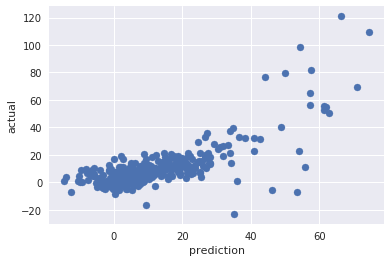

In [507]:
df = model_train_dict[model].copy()

target_t1 = [col for col in df.columns if 'T+1' in col][0]
X = df.drop([target_t1],axis=1)
y = df[target_t1]

#holdout
X, X_hold, y, y_hold = train_test_split(X,y,test_size=0.3)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

#model
#reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10),n_estimators=100)
reg = LinearSVR(C=.07, epsilon=5)
#reg = RandomForestRegressor(n_estimators=200)
#reg = ElasticNet(l1_ratio=.7)

#model fit
reg.fit(X_train,y_train)
y_pred_add = reg.predict(X_test)
y_pred_add = pd.Series(y_pred_add)
y_pred_add.index = y_test.index
score = cross_val_score(reg,X,y,scoring='neg_mean_squared_error')
print(np.sqrt(-score).mean())

y_pred = reg.predict(X_hold)
print(r2_score(y_hold,y_pred))

plt.scatter(y_pred,y_hold)
plt.xlabel('prediction')
plt.ylabel('actual')

In [321]:
importance = pd.DataFrame(list(zip(X.columns,reg.feature_importances_)))
#importance = pd.DataFrame(list(zip(X.columns,reg.coef_)))
importance.columns = ['col','coef']
importance.sort_values(by='coef',ascending=False).head(10)

,col,coef
8,Avg Sale To List T-8,0.062001
98,Inventory Mom T-0,0.051848
9,Avg Sale To List T-9,0.048061
390,New Listings Mom T-12,0.047765
67,Homes Sold Mom T-11,0.040739
378,New Listings Mom T-0,0.039435
305,Median Sale Price Mom T-11,0.028431
11,Avg Sale To List T-11,0.019382
10,Avg Sale To List T-10,0.018504
100,Inventory Mom T-2,0.017743


In [286]:
df.head()

,"Median Sale Price Best ARMA (0, 2, 6)",Avg Sale To List T-0,Avg Sale To List T-1,Avg Sale To List T-2,Avg Sale To List T-3,Avg Sale To List T-4,Avg Sale To List T-5,Avg Sale To List T-6,Avg Sale To List T-7,Avg Sale To List T-8,...,Sold Above List Yoy T-4,Sold Above List Yoy T-5,Sold Above List Yoy T-6,Sold Above List Yoy T-7,Sold Above List Yoy T-8,Sold Above List Yoy T-9,Sold Above List Yoy T-10,Sold Above List Yoy T-11,Sold Above List Yoy T-12,Sold Above List Yoy T-13
Period End,,,,,,,,,,,,,,,,,,,,,
2014-05-31,7.523468,0.992800,0.991018,0.985870,0.981711,0.978165,0.979060,0.978637,0.981641,0.982266,...,0.028258,0.053509,0.026438,0.055612,0.049670,0.097852,0.078262,0.093140,0.112115,0.100744
2014-06-30,3.110487,0.991033,0.992800,0.991018,0.985870,0.981711,0.978165,0.979060,0.978637,0.981641,...,0.041148,0.028258,0.053509,0.026438,0.055612,0.049670,0.097852,0.078262,0.093140,0.112115
2014-07-31,0.478197,0.990514,0.991033,0.992800,0.991018,0.985870,0.981711,0.978165,0.979060,0.978637,...,0.041805,0.041148,0.028258,0.053509,0.026438,0.055612,0.049670,0.097852,0.078262,0.093140
2014-08-31,-1.577782,0.986117,0.990514,0.991033,0.992800,0.991018,0.985870,0.981711,0.978165,0.979060,...,0.044703,0.041805,0.041148,0.028258,0.053509,0.026438,0.055612,0.049670,0.097852,0.078262
2014-09-30,-9.748105,0.983735,0.986117,0.990514,0.991033,0.992800,0.991018,0.985870,0.981711,0.978165,...,0.039307,0.044703,0.041805,0.041148,0.028258,0.053509,0.026438,0.055612,0.049670,0.097852


# create error dicts (only works on original setup so i think its obsolete now)

In [65]:
#model_error_dict, city_error_dict = create_error_dicts(city_list,city_dict)

In [256]:
model_list = list(model_error_dict.keys())

# pickle dicts

In [234]:
import pickle

pickle.dump(city_dict, open("city_dict.p", "wb"))
pickle.dump(city_error_dict, open("city_error_dict.p", "wb"))
pickle.dump(model_error_dict, open("model_error_dict.p", "wb"))

# load pickled dicts

In [264]:
city_dict = pickle.load(open("city_dict.p", "rb"))
city_error_dict = pickle.load(open("city_error_dict.p", "rb"))
model_error_dict = pickle.load(open("model_error_dict.p", "rb"))

In [265]:
for model in model_list:
    print(model)
    print(model_error_dict[model].apply(rmse).mean())
    #model_error_dict[model].hist()
    #model_error_dict[model].plot(kind='box',rot=90,title=model,vert=False)
    #model_error_dict[model].plot(kind='box',title=model,vert=False,xlim=(-150,150))

Trend Error
425.197876157
Trend Seasonality Error
188.799333664
Best ARMA Add Error
198.142275801
Best SARMA Error
190.828623698
Best ARMA Error
198.649379382
Trend Seasonality Add Error
210.281620577


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


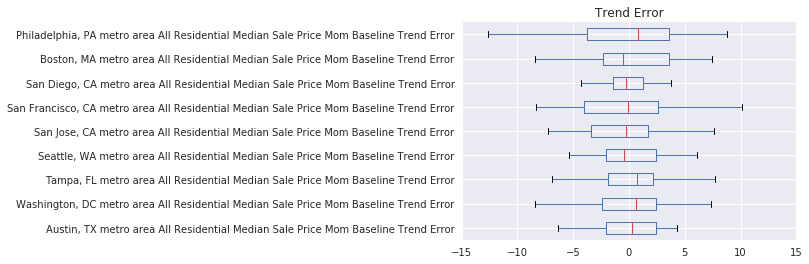

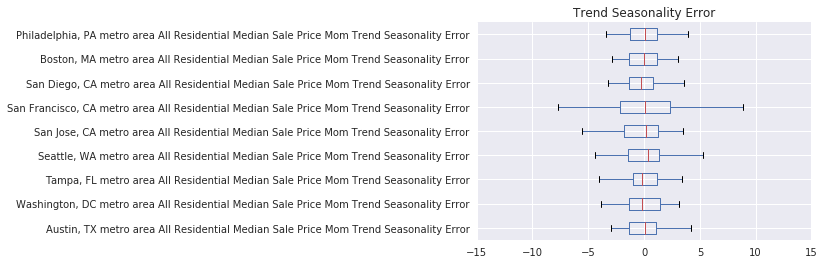

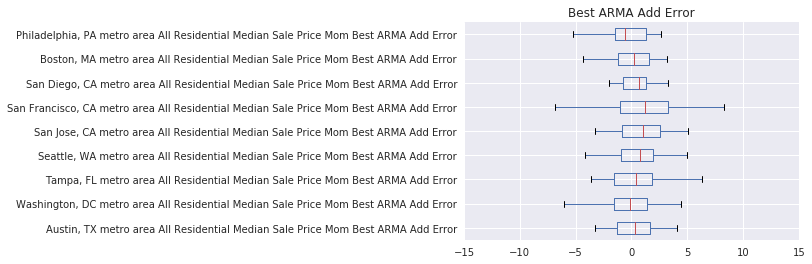

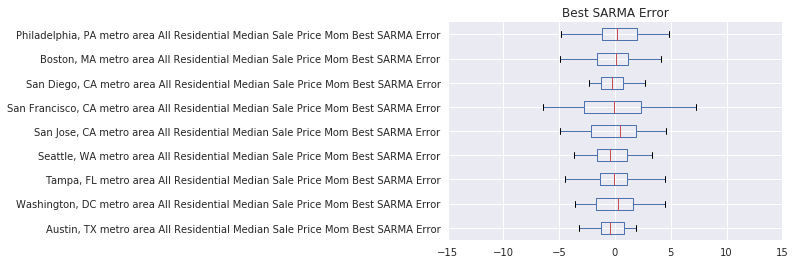

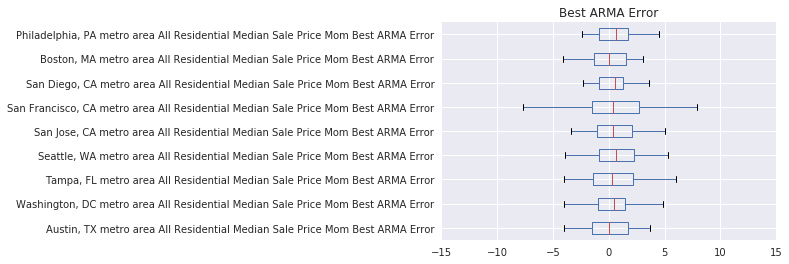

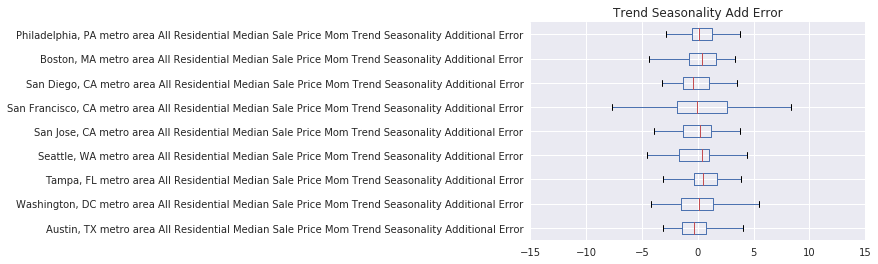

In [193]:
for model in model_list:
    model_error_dict[model].plot(kind='box',title=model,vert=False,xlim=(-15,15))

# distribution of model error

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


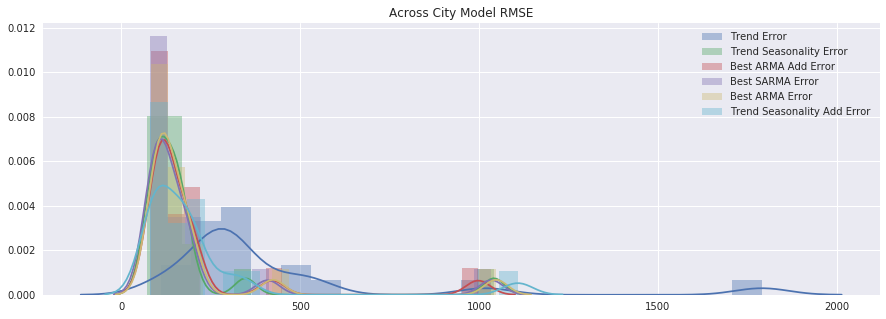

In [237]:
models = []
plt.figure(figsize=(15,5))
for model in model_error_dict.keys():
    sns.distplot(model_error_dict[model].apply(rmse),bins=20)
    models.append(model)
plt.legend(models)
plt.title('Across City Model RMSE')


/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


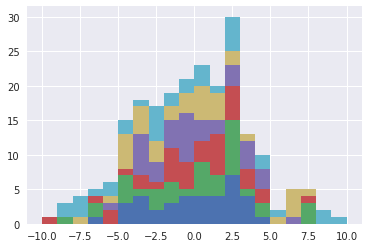

In [171]:
model = 'Trend Error'#'Trend Seasonality Add Error'
plt.hist([model_error_dict[model].iloc[:,0],
          model_error_dict[model].iloc[:,1],
          model_error_dict[model].iloc[:,2],
          model_error_dict[model].iloc[:,3],
          model_error_dict[model].iloc[:,4],
          model_error_dict[model].iloc[:,5]],
          bins=20, range=(-10,10), stacked=True)
plt.legend()

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


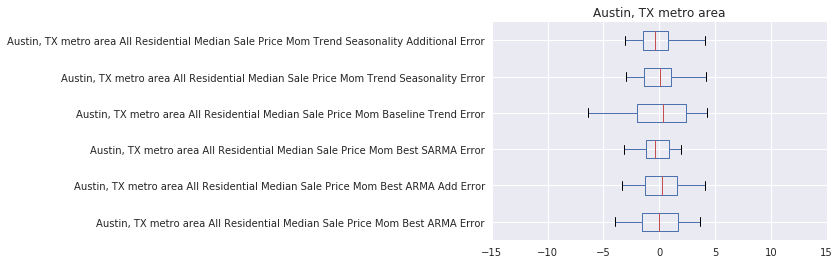

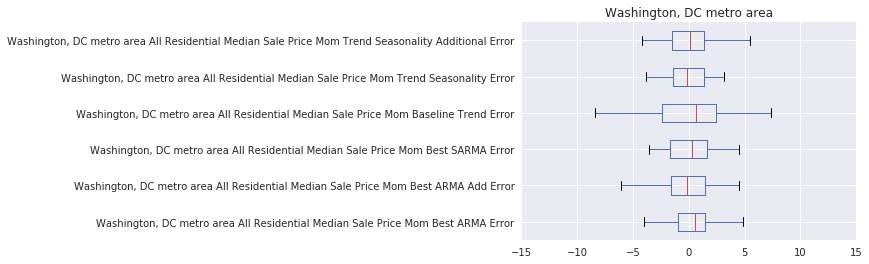

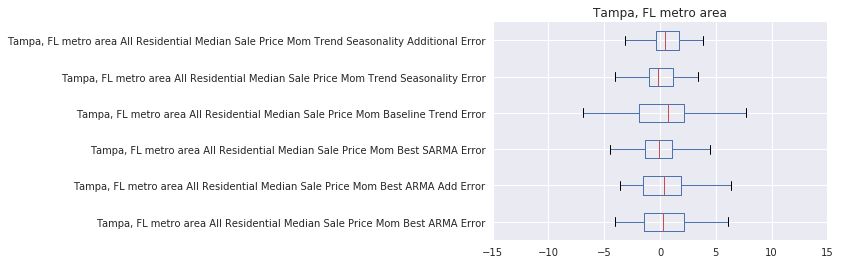

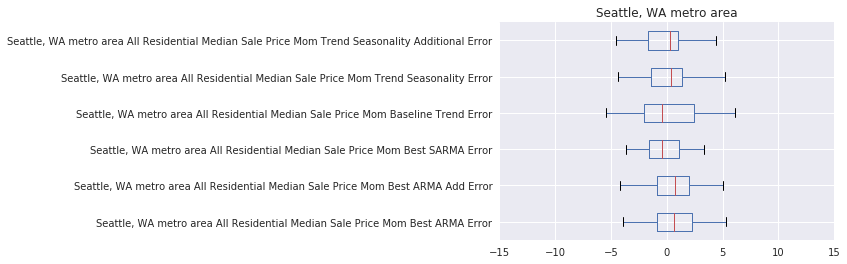

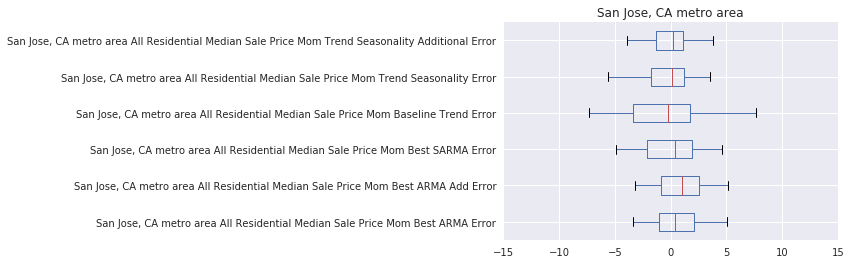

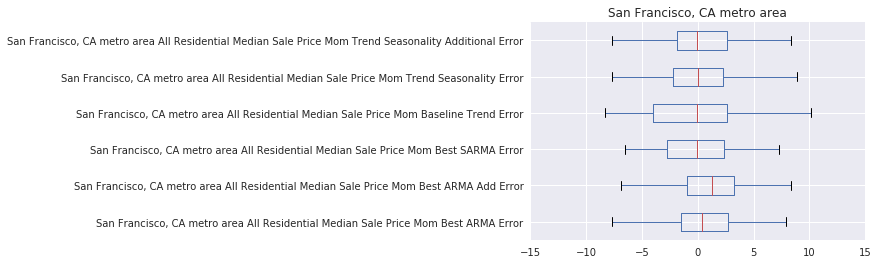

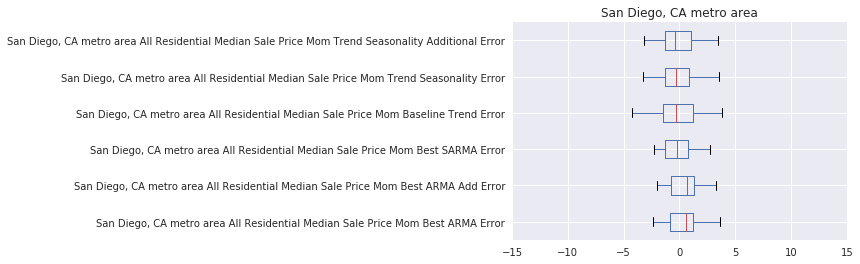

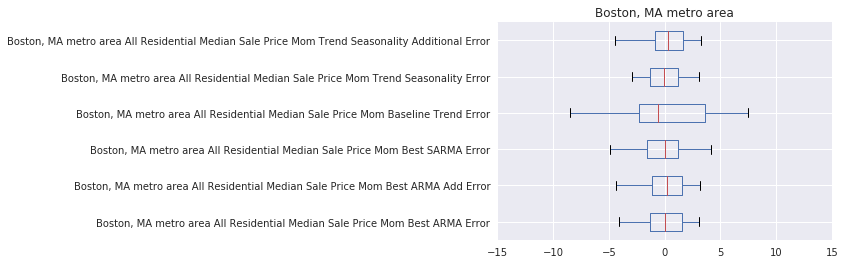

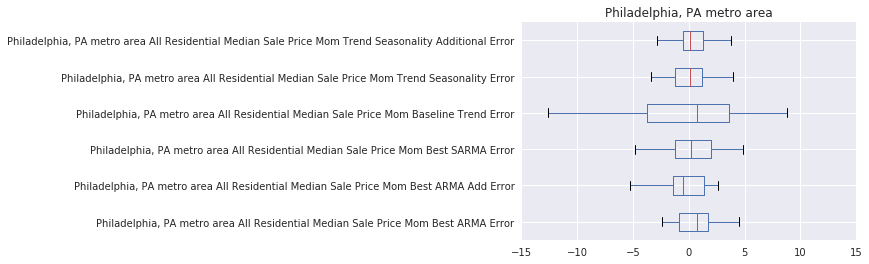

In [194]:
for city in city_list:
    city_error_dict[city].plot(kind='box',title=city,vert=False,xlim=(-15,15))

In [197]:
adf = df.copy()

In [198]:
sf_df = subset(adf,'San Francisco, CA metro area')
sf_df = subset(sf_df,'All Residential')

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


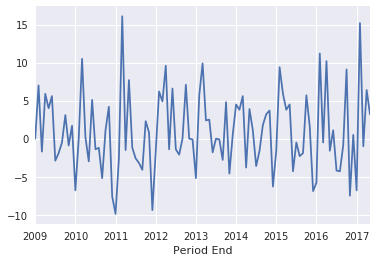

In [200]:
sf_df['San Francisco, CA metro area All Residential Median Sale Price Mom'].plot()

In [73]:
sj_df = subset(adf,'San Jose, CA metro area')
sj_df = subset(sj_df,'All Residential')

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


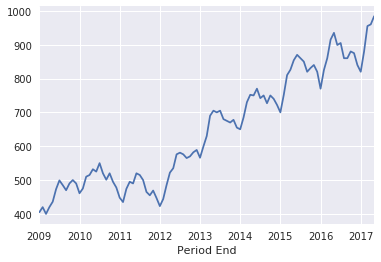

In [74]:
sj_df['San Jose, CA metro area All Residential Median Sale Price'].plot()

In [196]:
tp_df = subset(adf,'Tampa, FL metro area')
tp_df = subset(tp_df,'All Residential')

NameError: name 'adf' is not defined

In [195]:
tp_df['Tampa, FL metro area All Residential Median Sale Price Mom'].plot()

NameError: name 'tp_df' is not defined

In [96]:
city_list1 = city_list

In [141]:
city_list = ['Boston, MA metro area']

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


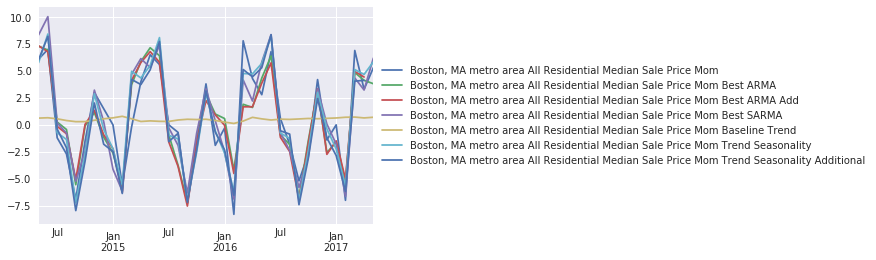

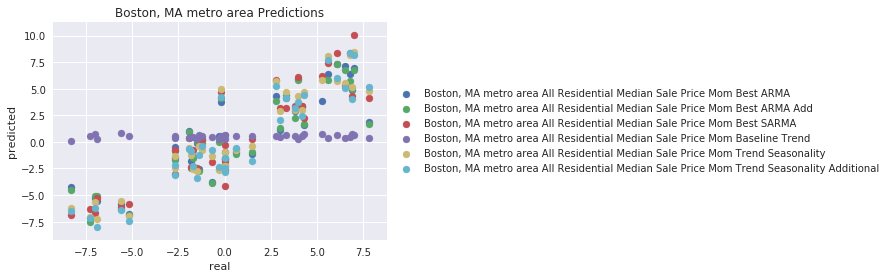

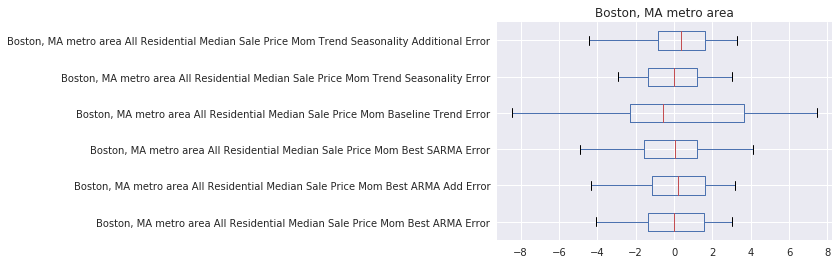

In [142]:
for city in city_list:
    city_dict[city].plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.figure()
    for i in range(len(city_dict[city].columns)-1):
        plt.scatter(city_dict[city].iloc[:,0],city_dict[city].iloc[:,i+1])
        plt.title(city+' Predictions')
        plt.xlabel('real')
        plt.ylabel('predicted')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     for i in range(len(city_error_dict[city].columns)-1):
#         plt.boxplot(city_error_dict[city].iloc[:,i])
#         plt.title(city+' Prediction Errors')
#         plt.xlabel('real')
#         plt.ylabel('predicted')
#         plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.figure()
    city_error_dict[city].plot(kind='box',title=city,vert=False)#,xlim=(-150,150))

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


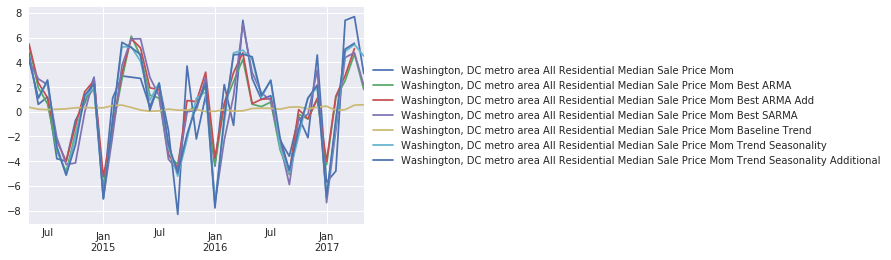

In [140]:
city_dict['Washington, DC metro area'].plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


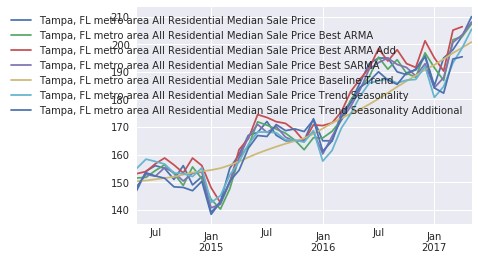

In [88]:
city_dict['Tampa, FL metro area'].plot()

In [78]:
city_dict[city].columns

Index(['Philadelphia, PA metro area All Residential Median Sale Price',
       'Philadelphia, PA metro area All Residential Median Sale Price Best ARMA',
       'Philadelphia, PA metro area All Residential Median Sale Price Best ARMA Add',
       'Philadelphia, PA metro area All Residential Median Sale Price Best SARMA',
       'Philadelphia, PA metro area All Residential Median Sale Price Baseline Trend',
       'Philadelphia, PA metro area All Residential Median Sale Price Trend Seasonality',
       'Philadelphia, PA metro area All Residential Median Sale Price Trend Seasonality Additional'],
      dtype='object')

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


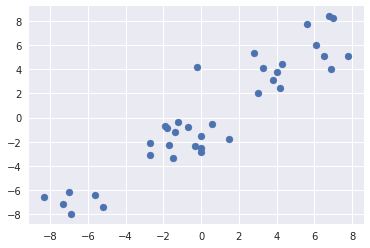

In [181]:
plt.scatter(city_dict[city].iloc[:,0],city_dict[city].iloc[:,6])